In [573]:
import ephem
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib widget

import time

import odrive
from odrive.enums import *

import scipy

from scipy.linalg import expm, norm

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.tri import Triangulation

import adi

from ipywidgets import IntProgress, FloatProgress, Label
from IPython.display import display

import skrf as rf

import pickle

In [2]:
s_antenna = rf.Network('sband.s1p')

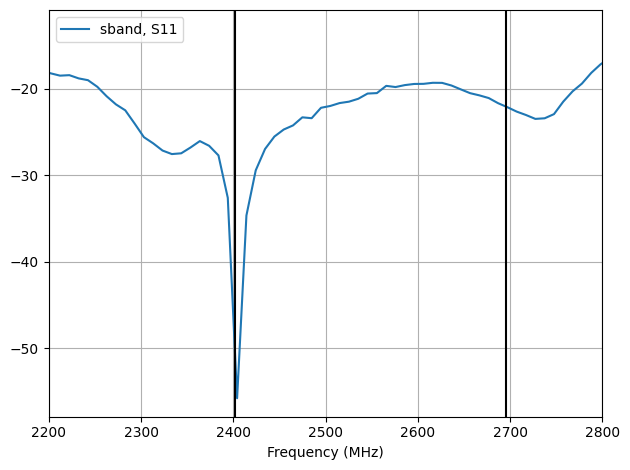

In [3]:
plt.figure()
s_antenna.plot_s_db(m=0, n=0)
plt.axvline(2.402e9, color='black')
plt.axvline(2.695e9, color='black')
plt.xlim(2.2e9, 2.8e9)
plt.grid()
plt.tight_layout()

In [613]:
dish = ephem.Observer()
dish.lon = '-105.251825'
dish.lat = '40.010886'
dish.elevation = 1605 # Meters

sat = ephem.readtle('ISS (ZARYA)',
    '1 25544U 98067A   23282.30784722  .00020103  00000+0  35964-3 0  9995',
    '2 25544  51.6405 123.2746 0005141  89.6288 248.8929 15.49967065419480'
)

pass_start = datetime(2023, 10, 9, 16, 56, 0, 0)
pass_end = datetime(2023, 10, 9, 17, 6, 0, 0)


times = []
positions = []

current_time = pass_start
while(current_time < pass_end):
    dish.date = current_time
    sat.compute(dish)

    times.append(current_time)
    positions.append([sat.alt, sat.az])

    current_time += timedelta(seconds = 1)

positions = np.array(positions).astype(float)

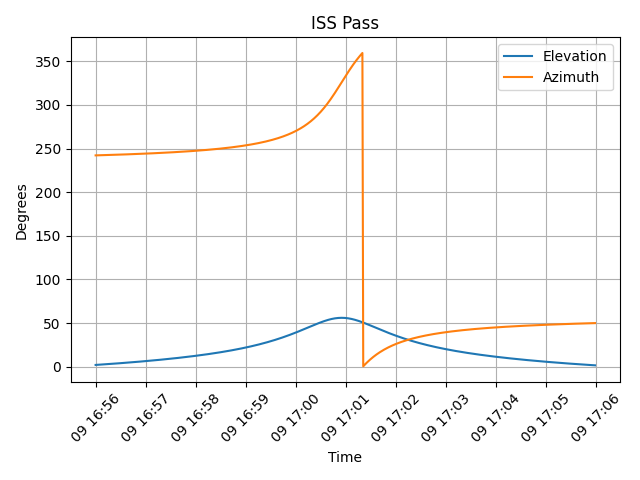

In [614]:
plt.figure()

plt.title("ISS Pass")

plt.ylabel("Degrees")
plt.xlabel("Time")
plt.xticks(rotation=45)

plt.plot(times, np.degrees(positions[:, 0]), label="Elevation")
plt.plot(times, np.degrees(positions[:, 1]), label="Azimuth")

plt.grid()
plt.legend()
plt.tight_layout()

In [341]:
odrv0 = odrive.find_any()

In [599]:
print(str(odrv0.vbus_voltage))

23.52055549621582


In [258]:
odrv0.axis1.encoder.config.use_index = True

In [313]:
#odrv0.axis0.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH
odrv0.axis1.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH

In [314]:
#odrv0.axis0.requested_state = AXIS_STATE_ENCODER_OFFSET_CALIBRATION
odrv0.axis1.requested_state = AXIS_STATE_ENCODER_OFFSET_CALIBRATION

In [318]:
odrv0.axis0.requested_state = AXIS_STATE_IDLE
odrv0.axis1.requested_state = AXIS_STATE_IDLE

In [315]:
odrv0.axis1.encoder.config.direction

-1

In [316]:
#odrv0.axis0.encoder.config.pre_calibrated = True
odrv0.axis1.encoder.config.pre_calibrated = True

In [ ]:
odrv0.save_configuration()

In [336]:
#odrv0.axis0.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH
odrv0.axis1.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH

In [170]:
odrv0.clear_errors()
odrv0.axis0.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE

In [324]:
odrv0.clear_errors()
odrv0.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
odrv0.axis0.controller.config.input_mode = INPUT_MODE_TRAP_TRAJ
odrv0.axis0.trap_traj.config.accel_limit = 0.5
odrv0.axis0.trap_traj.config.decel_limit = 0.5
odrv0.axis0.trap_traj.config.vel_limit = 5.0
odrv0.axis0.controller.config.vel_limit = 5
odrv0.axis0.controller.config.inertia = 0.0

In [325]:
odrv0.axis0.encoder.pos_estimate

0.00012207026884425431

In [295]:
3199/3600

0.8886111111111111

In [334]:
odrv0.axis0.controller.input_pos = 0

In [ ]:
# 320 is 1 revolation

In [ ]:
odrv0.reboot()

In [337]:
odrv0.clear_errors()
odrv0.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
odrv0.axis1.controller.config.input_mode = INPUT_MODE_TRAP_TRAJ
odrv0.axis1.trap_traj.config.accel_limit = 0.5
odrv0.axis1.trap_traj.config.decel_limit = 0.5
odrv0.axis1.trap_traj.config.vel_limit = 5.0
odrv0.axis1.controller.config.vel_limit = 5
odrv0.axis1.controller.config.inertia = 0.0

In [338]:
odrv0.axis1.encoder.pos_estimate

9.918212890625e-05

In [340]:
odrv0.axis1.controller.input_pos = 0

In [ ]:
# 80.5 is 90 deg

In [601]:
odrv0.axis0.controller.config.input_filter_bandwidth = 5
odrv0.axis1.controller.config.input_filter_bandwidth = 5

In [602]:
odrv0.clear_errors()
odrv0.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
odrv0.axis0.controller.config.input_mode = INPUT_MODE_POS_FILTER

In [603]:
odrv0.clear_errors()
odrv0.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
odrv0.axis1.controller.config.input_mode = INPUT_MODE_POS_FILTER

In [14]:
def generate_points(N = 10000, M = 50):

    t = np.linspace(0, 2*N//M, N//M)[1:]

    z = -((t-1)-N)/N
    x = np.cos(np.sqrt(N*np.pi)*np.arcsin(z))*np.sqrt(1-z**2)
    y = np.sin(np.sqrt(N*np.pi)*np.arcsin(z))*np.sqrt(1-z**2)

    return x, y, z

In [15]:
def compute_sun_position(dt):
    sun = ephem.Sun()
    dish.date = dt
    sun.compute(dish)

    return sun.az, sun.alt

In [16]:
def rotate_points(points, az, el):
    def M(axis, theta):
        return expm(np.cross(np.eye(3), axis/norm(axis)*theta))
    
    axis, theta = np.array([np.sin(az-np.pi/2),np.cos(az-np.pi/2),0]), np.pi/2-el
    M0 = M(axis, theta)
    return np.dot(M0, points)

In [17]:
def plot_points(points, s=1, colors=None, cmap=None):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.scatter(points[0, :], points[1, :], points[2, :], s=s, c=colors, cmap=cmap)

96.04767739185007 -1.5137515604180656


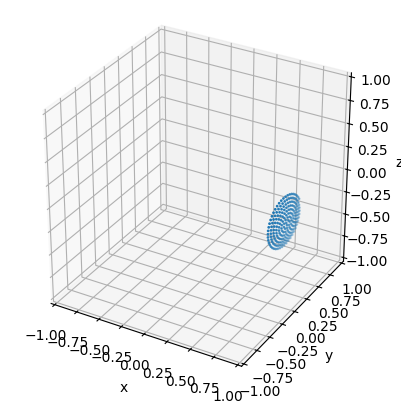

In [18]:
x, y, z = generate_points()
az, el = compute_sun_position(datetime(2023, 10, 9, 12, 56, 0, 0))
print(np.degrees(az), np.degrees(el))
points = np.vstack((x, y, z))
pts2 = rotate_points(points, az, el)
plot_points(pts2)

96.04767739185007 -1.5137515604180656
116.58672558461707 19.423463150345064
144.20462281432032 36.932844332969516
182.65754965273825 43.59033558491308
219.95005467192772 35.056676745331636
246.22176259735647 16.655725357136035


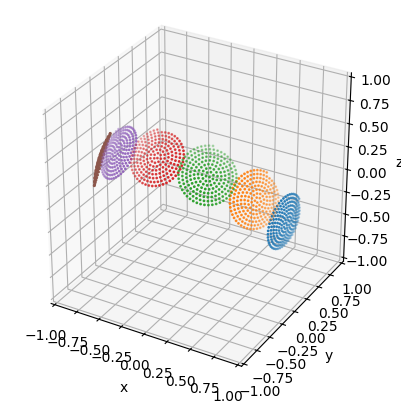

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

x, y, z = generate_points()
for hr in range(12, 24, 2):

    az, el = compute_sun_position(datetime(2023, 10, 9, hr, 56, 0, 0))
    print(np.degrees(az), np.degrees(el))
    pts2 = rotate_points(points, az, el)

    ax.scatter(pts2[0, :], pts2[1, :], pts2[2, :], s=1)

In [20]:
# Create transmit waveform (QPSK, 16 samples per symbol)
num_symbols = 1000
x_int = np.random.randint(0, 4, num_symbols) # 0 to 3
x_degrees = x_int*360/4.0 + 45 # 45, 135, 225, 315 degrees
x_radians = x_degrees*np.pi/180.0 # sin() and cos() takes in radians
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) # this produces our QPSK complex symbols
samples = np.repeat(x_symbols, 16) # 16 samples per symbol (rectangular pulses)
samples *= 2**14 # The PlutoSDR expects samples to be between -2^14 and +2^14, not -1 and +1 like some SDRs

In [ ]:
sample_rate = 1e6 # Hz
center_freq = 2.4e9 # Hz
num_samps = 100000 # number of samples per call to rx()

sdr2 = adi.Pluto("ip:192.168.3.1")
sdr2.sample_rate = int(sample_rate)

# Config Tx
sdr2.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr2.tx_lo = int(center_freq)
sdr2.tx_hardwaregain_chan0 = 0 # Increase to increase tx power, valid range is -90 to 0 dB

# Start the transmitter
sdr2.tx_cyclic_buffer = True # Enable cyclic buffers
sdr2.tx(samples) # start transmitting

In [ ]:
# Stop transmitting
sdr2.tx_destroy_buffer()

In [ ]:
plt.figure()
NFFT = 256
Fs = sample_rate
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
Pxx, freqs, bins, im = plt.gca().specgram(samples, NFFT=NFFT, Fs=Fs, noverlap=10)
plt.tight_layout()

In [ ]:
sdr2 = adi.Pluto('ip:192.168.3.1')

sdr2._output_byte_filename = "out.bin"
sdr2._push_to_file = True

# Pass data to object to generate data

sdr2.tx(samples)

In [ ]:
iio_attr -a -c ad9361-phy TX_LO frequency 2400000000 
iio_attr -a -c -o ad9361-phy voltage0 sampling_frequency 32000000
iio_attr -a -c -o ad9361-phy voltage0 hardwaregain 0
iio_attr -a -D ad9361-phy bist_tone "1 0 0 0"

In [343]:
sample_rate = 1e6 # Hz
#center_freq = 915e6
center_freq = 2.4006e9
#center_freq = 2.3996e9
#center_freq = 2.695e9
num_samps = 10000 # number of samples returned per call to rx()

sdr = adi.Pluto('ip:192.168.2.1')
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 70.0 # dB
sdr.rx_lo = int(center_freq)
sdr.sample_rate = int(sample_rate)
sdr.rx_rf_bandwidth = int(sample_rate) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size = num_samps

#sdr.rx_destroy_buffer()
samples = sdr.rx() # receive samples off Pluto
print(samples[0:10])

[-21. +4.j  -3.-10.j   1. +7.j  10. -5.j   9. +1.j  -1. +3.j  16.+12.j
  10. -7.j   4.-14.j -11.+16.j]


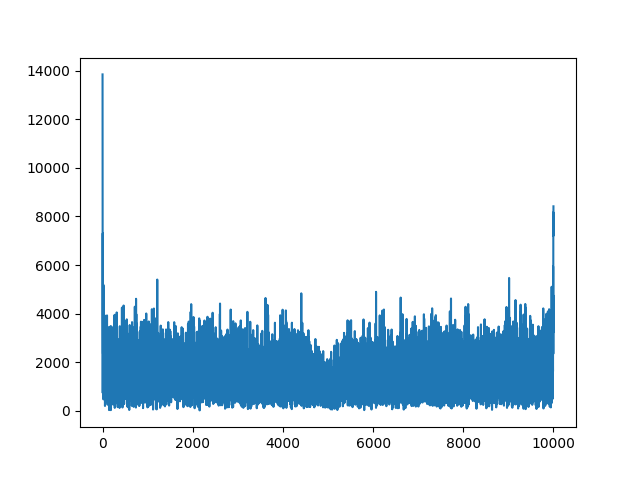

In [344]:
plt.figure()
plt.plot(np.abs(np.fft.fft(samples)))

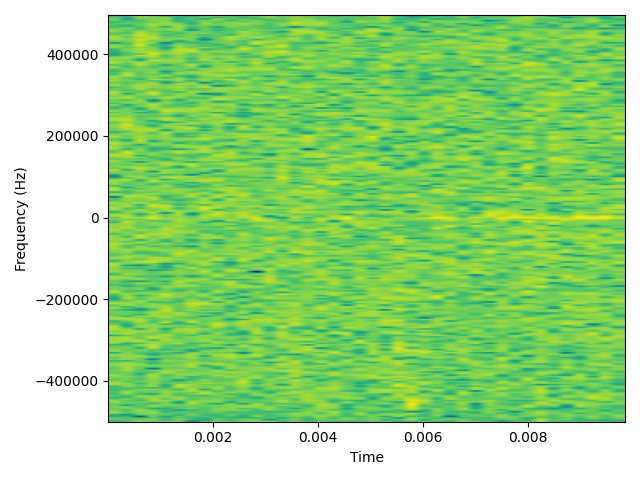

In [345]:
plt.figure()
NFFT = 256
Fs = sample_rate
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
Pxx, freqs, bins, im = plt.gca().specgram(samples, NFFT=NFFT, Fs=Fs, noverlap=10)
plt.tight_layout()

In [249]:
power_bar = IntProgress(min=0, max=10e6) # instantiate the bar
display(power_bar) # display the bar

IntProgress(value=0, max=10000000)

In [252]:
N = 100

pwrs = np.zeros(N)
kurt = np.zeros(N)
for i in range(N):

    time.sleep(0.5)

    sdr.rx_destroy_buffer()
    samples = sdr.rx()

    pwrs[i] = np.mean(np.abs(samples)**2)
    #pwrs[i] = np.max(np.abs(np.fft.fft(samples)))
    kurt[i] = scipy.stats.kurtosis(np.real(samples))

    power_bar.value = pwrs[i]

KeyboardInterrupt: 

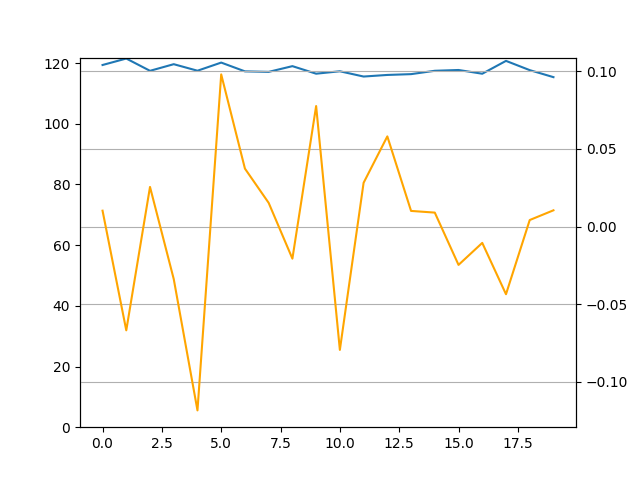

In [235]:
plt.figure()
plt.plot(pwrs)
plt.ylim(ymin=0)
plt.twinx().plot(kurt, color='orange')
plt.grid()

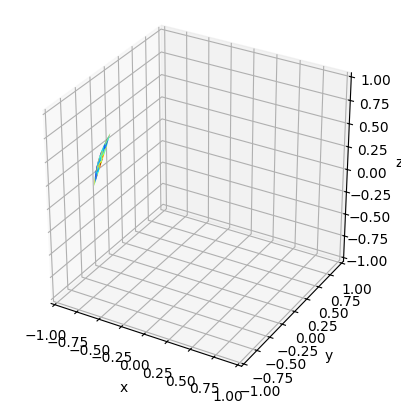

In [47]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
triangles = Triangulation(points[0], points[1])
surf = ax.plot_trisurf(pts2[0], pts2[1], pts2[2], triangles=triangles.triangles, antialiased=True)
surf.set_fc(cm.jet(Normalize()(np.mean(pwrs[triangles.triangles], axis=1))))

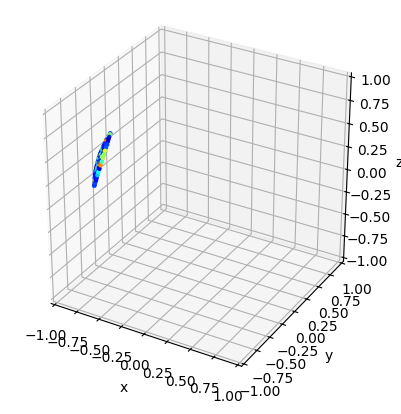

In [48]:
plot_points(pts2, s=5,colors=pwrs,cmap='jet')

In [49]:
print(np.degrees(az), np.degrees(el))

246.22176259735647 16.655725357136035


In [572]:
offset = datetime.utcnow() - pass_start

In [604]:
el_label = Label()
display(el_label)

Label(value='')

In [605]:
dish = ephem.Observer()
dish.lon = '-105.251825'
dish.lat = '40.010886'
dish.elevation = 1605 # Meters

sat = ephem.readtle('ISS (ZARYA)',
    '1 25544U 98067A   23282.30784722  .00020103  00000+0  35964-3 0  9995',
    '2 25544  51.6405 123.2746 0005141  89.6288 248.8929 15.49967065419480'
)

pass_start = datetime(2023, 10, 9, 16, 56, 0, 0)
pass_end = datetime(2023, 10, 9, 17, 6, 0, 0)

offset = datetime.utcnow() - pass_start - timedelta(seconds=60)

pass_start_elevation = 8

def get_current_time():
    return datetime.utcnow() - offset

dish.date = get_current_time()
sat.compute(dish)

el_label.value = f'{np.degrees(sat.alt):3.2f} EL {np.degrees(sat.az):3.2f} AZ F'

# Wait for satellite to come above horizon
while sat.alt < np.radians(pass_start_elevation):

    time.sleep(1)
    dish.date = get_current_time()
    sat.compute(dish)

    el_label.value = f'{np.degrees(sat.alt):3.2f} EL {np.degrees(sat.az):3.2f} AZ W'

times = []
az_tgt = []
el_tgt = []
az_meas = []
el_meas = []

# Track satellite and record data
while sat.alt >= np.radians(pass_start_elevation):

    current_time = get_current_time()
    dish.date = current_time
    sat.compute(dish)

    el_label.value = f'{np.degrees(sat.alt):3.2f} EL {np.degrees(sat.az):3.2f} AZ R'

    # Handle crossing 360
    if len(az_tgt) == 0:
        az_last = np.degrees(sat.az)
    else:
        az_last = az_tgt[-1]
    az_next = np.degrees(sat.az)
    az_diff = az_next - az_last
    az_diff = (((az_diff + 180) % 360 ) - 180)

    az_tgt.append(az_last + az_diff)
    el_tgt.append(np.degrees(sat.alt))

    # TODO offset correction
    
    a0_tgt = (az_tgt[-1] - 180) * (3199 / 3600)
    a1_tgt = (90 - el_tgt[-1]) * (3199 / 3600)

    odrv0.axis0.controller.input_pos = a0_tgt
    odrv0.axis1.controller.input_pos = a1_tgt

    a0_pos = odrv0.axis0.encoder.pos_estimate
    a1_pos = odrv0.axis1.encoder.pos_estimate

    az_meas.append( (a0_pos /  (3199 / 3600) ) + 180 )
    el_meas.append( 90 - (a1_pos / (3199 / 3600) ) )
    
    times.append(current_time)

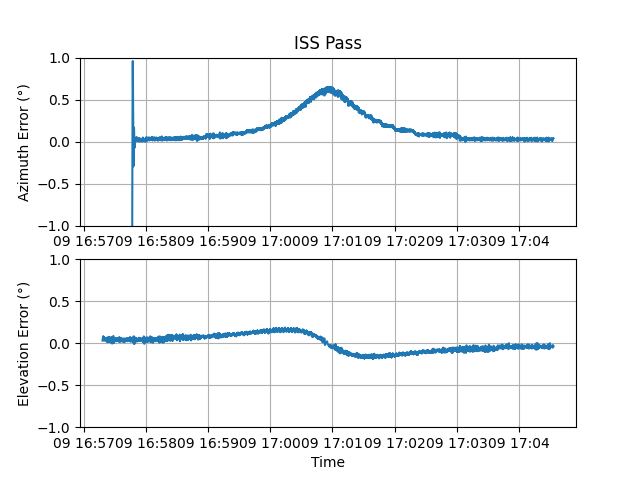

In [611]:
plt.figure()

plt.subplot(211)
plt.title("ISS Pass")
plt.ylabel("Azimuth Error (°)")
plt.plot(times, np.array(az_tgt)-np.array(az_meas))
plt.ylim(-1, 1)
plt.grid()

plt.subplot(212)
plt.ylabel("Elevation Error (°)")
plt.xlabel("Time")
plt.plot(times, np.array(el_tgt)-np.array(el_meas))
plt.ylim(-1, 1)
plt.grid()

219.05702109832689 32.89465891073955


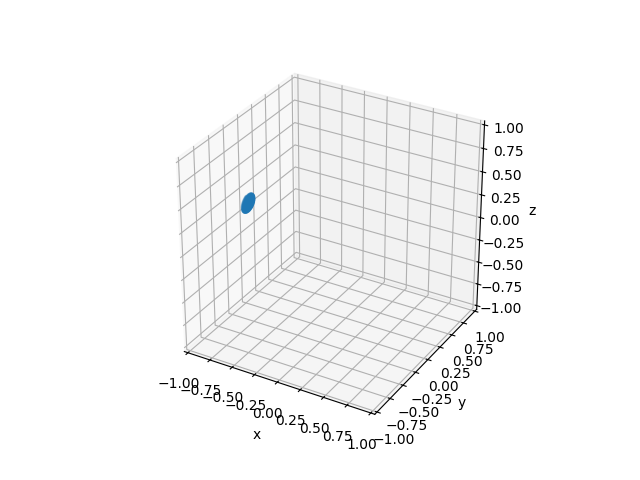

In [556]:
x, y, z = generate_points(N = 80000, M = 400)

az, el = compute_sun_position(datetime.utcnow())

print(np.degrees(az), np.degrees(el))

points = np.vstack((x, y, z))
pts2 = rotate_points(points, az, el)


# Filter points above horizon
points = points[:, pts2[2,:] > 0]
pts2 = pts2[:, pts2[2,:] > 0]

plot_points(pts2)

In [557]:
#az_tgt = np.degrees(np.arctan2(pts2[0], pts2[1])) % 360
#el_tgt = np.degrees(np.arctan2(pts2[2], np.sqrt(pts2[0]**2 + pts2[1]**2))) % 360

#az = np.radians(260.8)
#el = np.radians(3)
N = 16

#az_tgt = np.linspace(np.degrees(az) - 10, np.degrees(az) + 10, N)
#el_tgt = np.degrees(el).repeat(N)

az += np.radians(16)

M = 16
az_tgt = np.linspace(np.degrees(az) - 4, np.degrees(az) + 4, N)
az_tgt = np.tile(np.hstack((az_tgt, np.flip(az_tgt))), M)
el_tgt = np.linspace(np.degrees(el)- 4, np.degrees(el) + 4, 2*M).T.repeat(N).flatten()

# unwrap az target so its consistent
az_tgt = np.unwrap(az_tgt, period=360)

pwrs = np.zeros(az_tgt.shape[0])
utc_times = np.zeros(az_tgt.shape[0], dtype='datetime64[ns]')
raw_samples = np.zeros((az_tgt.shape[0], num_samps), dtype=complex)

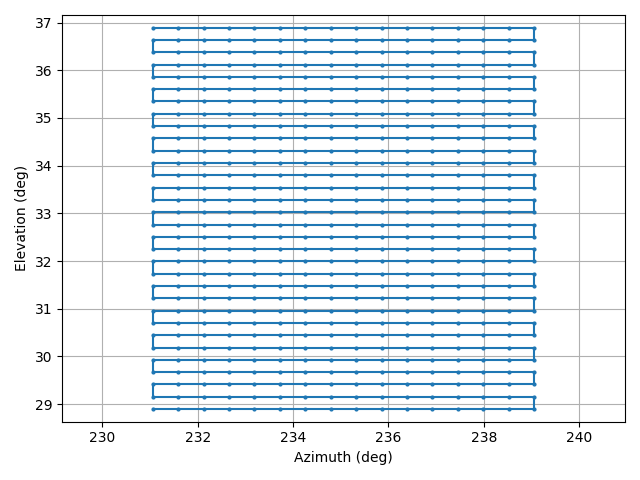

In [558]:
plt.figure()
plt.ylabel("Elevation (deg)")
plt.xlabel("Azimuth (deg)")
plt.plot(az_tgt, el_tgt, 'o-', markersize=2)
plt.axis('equal')
plt.grid()
plt.tight_layout()

Text(0, 0.5, 'Elevation Target')

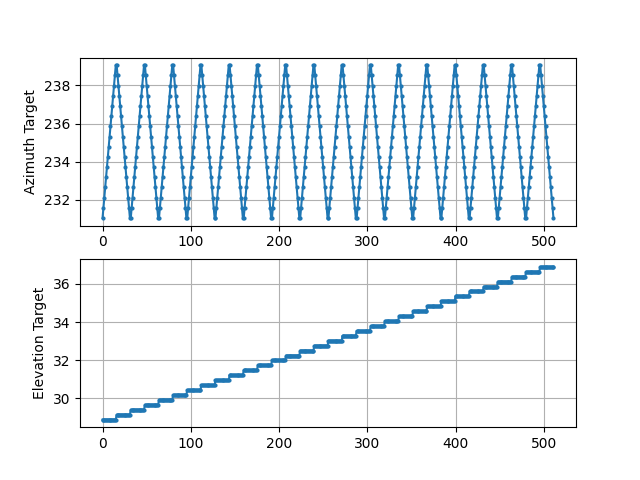

In [559]:
_, [ax1, ax2] = plt.subplots(2, 1)

ax1.plot(az_tgt, 'o-', markersize=2)
ax1.grid()
ax1.set_ylabel("Azimuth Target")

ax2.plot(el_tgt, 'o-', markersize=2)
ax2.grid()
ax2.set_ylabel("Elevation Target")


In [560]:
a0_tgt = np.zeros(pts2.shape[1])
a1_tgt = np.zeros(pts2.shape[1])

# convert from degrees to encoder revolutions
# and account for estimated azimuth 0 offset
# 0 is south, so shift 180
a0_tgt = (az_tgt - 180) * (3199 / 3600)
# 0 is vertical, so 90 - elevation
a1_tgt = (90 - el_tgt) * (3199 / 3600)

In [561]:
odrv0.axis0.controller.input_pos = a0_tgt[0]

In [562]:
odrv0.axis1.controller.input_pos = a1_tgt[0]

In [563]:
progress = IntProgress(min=0, max=az_tgt.shape[0]) # instantiate the bar
display(progress) # display the bar

IntProgress(value=0, max=512)

In [564]:
a0_pos = np.zeros(az_tgt.shape[0])
a1_pos = np.zeros(az_tgt.shape[0])

for i in range(az_tgt.shape[0]):

    # Move

    #print(az_tgt[i], el_tgt[i])

    odrv0.axis0.controller.input_pos = a0_tgt[i]
    odrv0.axis1.controller.input_pos = a1_tgt[i]

    # Delay
    time.sleep(0.5)

    # Get encoder positions
    a0_pos[i] = odrv0.axis0.encoder.pos_estimate
    a1_pos[i] = odrv0.axis1.encoder.pos_estimate
    #a0_pos[i] = a0_tgt[i]
    #a1_pos [i]= a1_tgt[i]

    # Record
    sdr.rx_destroy_buffer()
    samples = sdr.rx()
    utc_times[i] = datetime.utcnow()
    pwrs[i] = np.mean(np.abs(samples)**2)
    #pwrs[i] = np.max(np.abs(np.fft.fft(samples))[3900:3940])
    raw_samples[i] = samples

    progress.value = i
    
    #print(pwrs[i])
    #print()

In [565]:
az_meas = (a0_pos /  (3199 / 3600) ) + 180
el_meas = 90 - (a1_pos / (3199 / 3600) )

In [566]:
for i in range(az_meas.shape[0]):
    pwrs[i] = np.mean(np.abs(raw_samples[i])**2)
    #pwrs[i] = 10*np.log10(np.max(np.abs(np.fft.fft(raw_samples[i]))[3900:4050])**2)

Text(0, 0.5, 'Power')

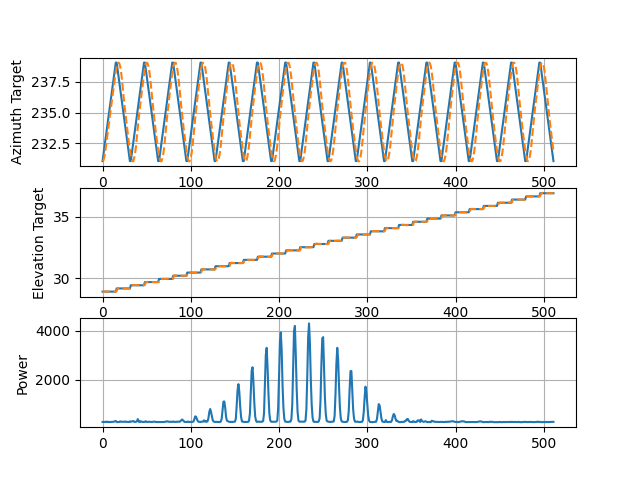

In [567]:
_, [ax1, ax2, ax3] = plt.subplots(3, 1)

ax1.plot(az_tgt)
ax1.plot(az_meas, '--')
ax1.grid()
ax1.set_ylabel("Azimuth Target")

ax2.plot(el_tgt)
ax2.plot(el_meas, '--')
ax2.grid()
ax2.set_ylabel("Elevation Target")

ax3.plot(pwrs)
ax3.grid()
ax3.set_ylabel("Power")

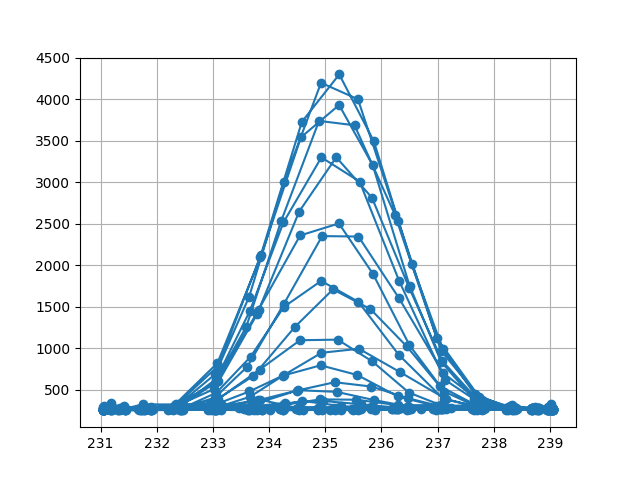

In [568]:
plt.figure()
plt.plot(az_meas, pwrs, 'o-')
#plt.ylim(105, 112)
plt.grid()

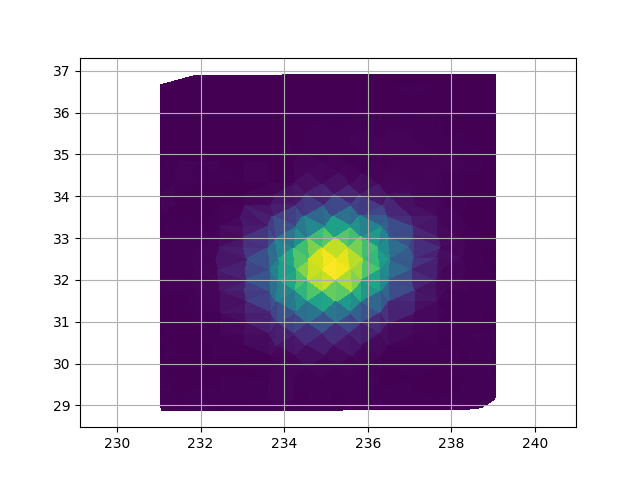

In [569]:
plt.figure()
plt.tripcolor(az_meas, el_meas, pwrs)
#plt.scatter(az_meas, el_meas, c=pwrs)
plt.axis('equal')
plt.grid()

In [146]:
np.where(pwrs > 350)

(array([ 661,  725,  856, 1001], dtype=int64),)

174.34207427501678
43.131778314246894
(array([9997], dtype=int64),)


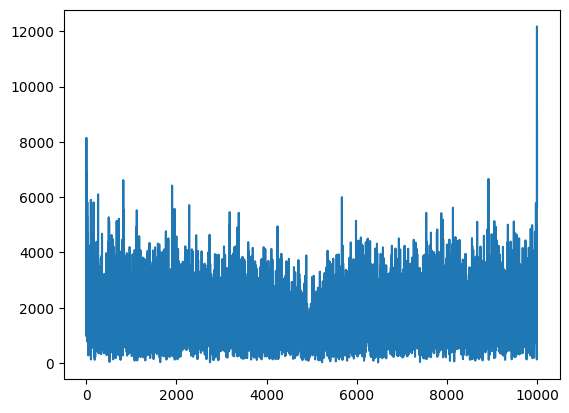

In [161]:
J = 725
print(az_meas[J])
print(el_meas[J])
plt.figure()
plt.plot(np.abs(np.fft.fft(raw_samples[J])))
print(np.where(np.abs(np.fft.fft(raw_samples[J])) > 10000))

396.9301
174.34207427501678
43.131778314246894


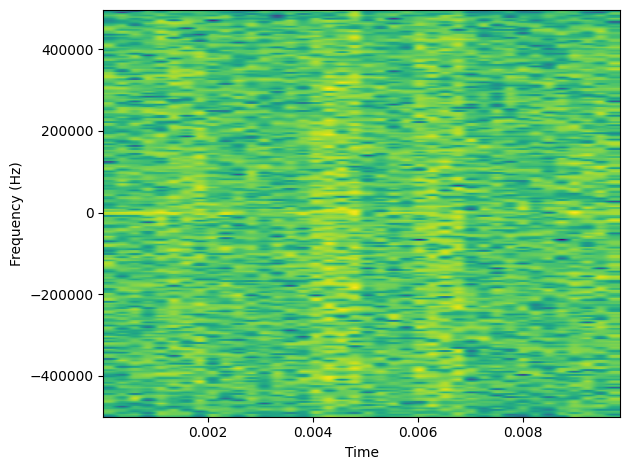

In [162]:
# 169 234

# 271.8, 2.3
# 271.5, 2.8

plt.figure()
NFFT = 256
Fs = sample_rate
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
Pxx, freqs, bins, im = plt.gca().specgram(raw_samples[J], NFFT=NFFT, Fs=Fs, noverlap=10)
#plt.ylim(350000, 450000)
plt.tight_layout()
print(pwrs[J])
print(az_meas[J])
print(el_meas[J])

In [570]:
name = 'scan_sun_13_10152023_'

In [571]:
np.save(name+'az_meas', az_meas)
np.save(name+'el_meas', el_meas)
np.save(name+'az_tgt', az_tgt)
np.save(name+'el_tgt', el_tgt)
np.save(name+'utc_times', utc_times)
np.save(name+'pwrs', pwrs)
np.save(name+'raw_samples', raw_samples)

In [608]:
odrv0.axis0.controller.input_pos = 0
odrv0.axis1.controller.input_pos = 0

In [ ]:
odrv0.axis1.controller.input_pos = 80

In [ ]:
np.degrees(np.arctan2(206, 3786))

In [ ]:
name = 'scan_c_'

In [ ]:
az_meas = np.load(name+'az_meas.npy')
el_meas = np.load(name+'el_meas.npy')
pwrs = np.load(name+'pwrs.npy')
raw_samples = np.load(name+'raw_samples.npy')

In [ ]:
fspl = 111
tx_pwr = 6.5 #dBm
nf = -174 # dBm/Hz
bin_bw = 100 # Hz

df = -154 #dBm

6.5-111-6